In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"


In [2]:
# 1. Load Data Splits
# ------------------------------------------------------------------------------
print("Loading split files...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")

Loading split files...
Train rows: 632426


In [3]:
# 2. Strict Feature Selection (Added Timestamps)
# ------------------------------------------------------------------------------

# A. Identifiers & Timing (Updated with Raw Timestamps)
feat_timing = [
    "day_idx", 
    "hour_of_day",
    "ts_vm_created",       # Added per request
    "ts_first_vm_created"  # Added per request (Tenant join time)
]

# B. Static VM Config & Deployment Metadata
feat_static = [
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour"
]

# C. Tenant History Features (Safe)
feat_history = [c for c in df_train.columns if c.startswith("hist_")]

# D. Categorical Features
feat_categorical = ["vm_category"]

# Combine
SAFE_NUMERIC_COLS = feat_timing + feat_static + feat_history
SAFE_CATEGORICAL_COLS = feat_categorical
ALL_SAFE_FEATURES = SAFE_NUMERIC_COLS + SAFE_CATEGORICAL_COLS

print(f"\nTotal Features: {len(ALL_SAFE_FEATURES)}")


Total Features: 23


In [4]:
# 3. Prepare X and y
# ------------------------------------------------------------------------------
def get_X_y(df_polars):
    X = df_polars.select(ALL_SAFE_FEATURES).to_pandas()
    y = df_polars.select(TARGET_COL).to_pandas().values.ravel()
    return X, y

X_train, y_train = get_X_y(df_train)
X_val, y_val     = get_X_y(df_val)
X_test, y_test   = get_X_y(df_test)

In [5]:
# 4. Build Robust Pipeline
# ------------------------------------------------------------------------------
# Numeric Pipeline: Median Imputation -> Scaling
# Scaling is CRITICAL here because ts_vm_created is ~2,000,000 while
# vm_virtual_core_count is ~4.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Unknown Imputation -> OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, SAFE_NUMERIC_COLS),
        ('cat', categorical_transformer, SAFE_CATEGORICAL_COLS)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        solver='lbfgs', 
        random_state=42
    ))
])

Training Logistic Regression...
Training Complete.
--- Validation Report ---
              precision    recall  f1-score   support

           0      0.841     0.885     0.863     90628
           1      0.700     0.616     0.655     39377

    accuracy                          0.804    130005
   macro avg      0.770     0.750     0.759    130005
weighted avg      0.798     0.804     0.800    130005

Validation ROC AUC: 0.8319
Confusion matrix (counts):
                      Pred: not critical  Pred: critical
Actual: not critical               75985           13188
Actual: critical                   16149           26527
Classification report:
              precision    recall  f1-score   support

           0      0.825     0.852     0.838     89173
           1      0.668     0.622     0.644     42676

    accuracy                          0.777    131849
   macro avg      0.746     0.737     0.741    131849
weighted avg      0.774     0.777     0.775    131849

Test ROC AUC: 0.8150


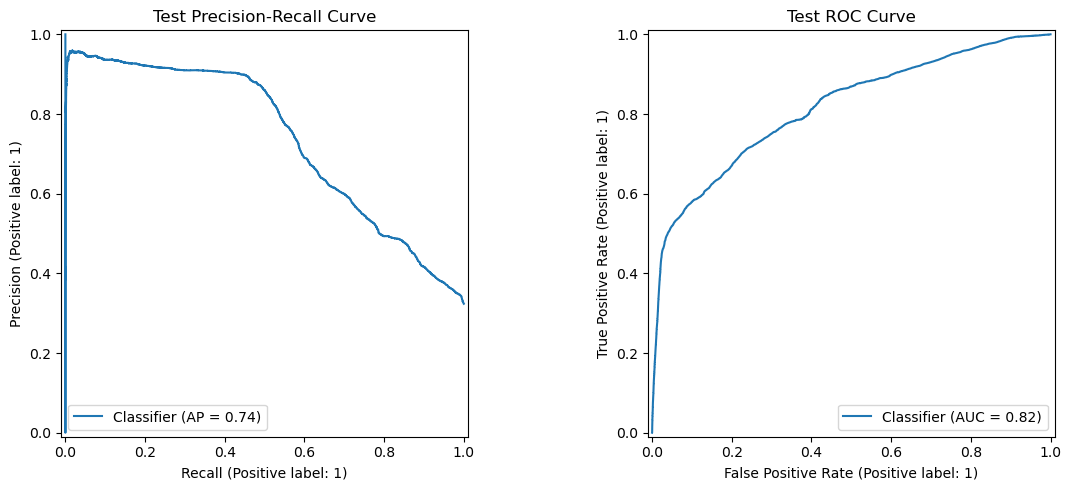

In [6]:
# 5. Train & Evaluate
# ------------------------------------------------------------------------------
print("Training Logistic Regression...")
model.fit(X_train, y_train)
print("Training Complete.")

# Validation
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

print("--- Validation Report ---")
print(classification_report(y_val, y_val_pred, digits=3))
print(f"Validation ROC AUC: {roc_auc_score(y_val, y_val_prob):.4f}")

# Test
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual: not critical", "Actual: critical"],
    columns=["Pred: not critical", "Pred: critical"],
)

print("Confusion matrix (counts):")
print(cm_df.to_string())

print("Classification report:")
print(classification_report(y_test, y_test_pred, digits=3))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Test PR AUC:  {average_precision_score(y_test, y_test_prob):.4f}")

# Side-by-side PR and ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_test_prob, ax=axes[0])
axes[0].set_title("Test Precision-Recall Curve")
RocCurveDisplay.from_predictions(y_test, y_test_prob, ax=axes[1])
axes[1].set_title("Test ROC Curve")
plt.tight_layout()
plt.show()


In [7]:
# 6. Feature Importance (Check if timestamps matter)
# ------------------------------------------------------------------------------
cat_names = model.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(SAFE_CATEGORICAL_COLS)
final_feature_names = SAFE_NUMERIC_COLS + list(cat_names)
coeffs = model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'feature': final_feature_names,
    'coefficient': coeffs,
    'abs_coeff': np.abs(coeffs)
}).sort_values(by='abs_coeff', ascending=False)

print("\nTop 10 Overall Features:")
print(coef_df.head(10))


Top 10 Overall Features:
                          feature  coefficient  abs_coeff
15             hist_critical_frac     1.289091   1.289091
18             hist_cpu_mean_mean     0.289503   0.289503
23        vm_category_Interactive     0.171391   0.171391
12                     hist_n_vms     0.145224   0.145224
13                hist_n_critical    -0.137462   0.137462
8             log_deployment_size     0.125455   0.125455
20            hist_frac_gt60_mean    -0.112085   0.112085
24             vm_category_Unkown    -0.101593   0.101593
22  vm_category_Delay-insensitive    -0.094469   0.094469
9               count_vms_created    -0.082556   0.082556
